# GBP/USD Exchange Rate during 2017 UK Election Night - Under Construction



In [65]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from sklearn import linear_model, datasets
import statsmodels.api as sm

import pandas as pd
from collections import OrderedDict
from datetime import date

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pylab

import tweepy

import json

import re
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [66]:
CONSUMER_KEY = '4BByuBKYk19fpSl5iMIkju3c0'
CONSUMER_SECRET = '2EK91aT0s7uMJ1oWECBRUwkXrxGykigrsmtqtOIAvFBPXiucQq'
ACCESS_TOKEN = '892729320736739328-E30nIY5dacqxeugxPoe3TXB2fIjITZB'
ACCESS_TOKEN_SECRET = 'WMViNA7y1d1trkb5nt7L5dOAHdScmYBMHm33sLeUVZrWT'


auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)
api = tweepy.API(auth)

tweets_raw = api.user_timeline(screen_name = 'bbcelection', count = 200, include_rts = False)
for i in range(0,5):
    oldest=tweets_raw[-1].id
    new_tweets = api.user_timeline(screen_name = 'bbcelection',count=200,max_id=oldest)
    tweets_raw.extend(new_tweets)

data = [[tw.created_at.year, tw.created_at.month, tw.created_at.day,"%s.%s"%(tw.created_at.hour, tw.created_at.minute), tw.id_str, tw.text.encode("utf8")] for tw in tweets_raw ]
tweets=pd.DataFrame(data, columns=['year','month','date','time','tweet_id','tweet'])


In [67]:
# Wikipedia data
UKpoll = pd.read_csv('data/UK2017Poll.txt', sep='\t', header=0)
UKpoll.columns=['Con_poll', 'Lab_poll', 'Lib_poll','SNP_poll','Pla_poll','Greens_poll',\
                'UKIP_poll', 'Other_poll', 'Seat','Region','2015']
results = pd.read_csv("data/result.csv")

In [68]:
tweets.tweet=tweets.tweet.astype(str)
tweets_cleaned = tweets[tweets.tweet.str.contains('#GE2017')]
tweets_cleaned['time_full'] = tweets_cleaned["year"].map(str)+ "/"+ tweets_cleaned["month"].map(str) + \
    "/"+ tweets_cleaned["date"].map(str)  + "/"+ tweets_cleaned["time"].map(str) 

C:\Users\AlexH\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Merging result data with time

In [69]:
results['time']=np.nan
for i in range(len(results)):
    tw = tweets_cleaned.tweet.str.contains(str(results.Constituency[i]))

    if True not in tw.tolist():
        
        #finds closes match
        max_score=0 
        for j in range(len(tweets_cleaned)):        
            score = fuzz.token_set_ratio(str(results.Constituency[i]),str(tweets_cleaned.tweet[j]))
            if score > max_score:
                tw_ind = j
                max_score=score
    else:
        tw_ind = tw.tolist().index(True)

        
    
    results['time'].loc[i]= datetime.strptime(tweets_cleaned.time_full[i],'%Y/%m/%d/%H.%M')
    
results[['Con[b]','Lab[c]','LD','SNP','UKIP','Grn[d]','DUP']]=(results[['Con[b]','Lab[c]','LD','SNP','UKIP','Grn[d]','DUP']].T/results['Total']).T

C:\Users\AlexH\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\AlexH\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  This is separate from the ipykernel package so we can avoid doing imports until


## Merging poll with result

In [70]:
full_table = pd.merge(results, UKpoll,  how='left', left_on='Constituency', right_on = 'Seat')
full_table = full_table.sort_values(by='time').reset_index(drop=True)

## Other factors
taken from UK sensus 

In [71]:
xl = pd.ExcelFile("data/Wages.xlsx")
wages=xl.parse("Data")
wages.head()
full_table = pd.merge(full_table, wages,  how='left', left_on='Constituency', right_on = 'ConstituencyName')

xl = pd.ExcelFile("data/Business-numbers.xlsx")
business=xl.parse("Data")
#full_table = pd.merge(full_table, business,  how='left', left_on='Constituency', right_on = 'ConstituencyName')

xl = pd.ExcelFile("data/Population-by-age.xlsx")
population=xl.parse("Data")
full_table = pd.merge(full_table, population,  how='left', left_on='Constituency', right_on = 'ConstituencyName')

full_table.columns

Index(['Constituency', 'Cnty', 'Rgn', 'Last Election', 'Party', 'Votes',
       'Share', 'Majrty', 'turnout', 'Con[b]', 'Lab[c]', 'LD', 'SNP', 'UKIP',
       'Grn[d]', 'DUP', 'SF', 'PC', 'SDLP', 'UUP', 'APNI', 'Other[e]', 'Total',
       'time', 'Con_poll', 'Lab_poll', 'Lib_poll', 'SNP_poll', 'Pla_poll',
       'Greens_poll', 'UKIP_poll', 'Other_poll', 'Seat', 'Region', '2015',
       'ONSConstID_x', 'ConstituencyName_x', 'RegionID_x', 'RegionName_x',
       'CountryID_x', 'CountryName_x', 'DateOfThisUpdate', 'DateOfDataset_x',
       'WageMedianConst', 'WageMedianRegion', 'WageMedianCountry',
       'WageConstCountryRank', 'ONSConstID_y', 'ConstituencyName_y',
       'RegionID_y', 'RegionName_y', 'CountryID_y', 'CountryName_y',
       'DateThisUpdate', 'DateOfDataset_y', 'Pop0-19ConstNum',
       'Pop0-19ConstRate', 'Pop20-64ConstNum', 'Pop20-64ConstRate',
       'Pop65ConstNum', 'Pop65ConstRate', 'PopTotalConstNum', 'Pop0-19RegNum',
       'Pop0-19RegRate', 'Pop20-64RegNum', 'Pop20-6

In [72]:
X_lib

,const,Lib_poll,Last Election,WageMedianConst,Pop65ConstRate
0,1.0,11.0,0,580.0,0.231547
1,1.0,13.0,0,480.0,0.133513
4,1.0,5.0,0,460.0,0.144057
5,1.0,3.0,0,470.0,0.238294
6,1.0,7.0,0,550.0,0.249328
7,1.0,10.0,0,570.0,0.142310
8,1.0,6.0,0,520.0,0.192668
9,1.0,9.0,0,520.0,0.284174
10,1.0,4.0,0,500.0,0.164095
11,1.0,5.0,0,530.0,0.226251


## Analysis

In [73]:
columns = ['time', 'Constituency','low', 'ave', 'high']
index= full_table.index
pred=pd.DataFrame(index=index, columns=columns)

sim_num = 50
for i in range(8,len(full_table)-7):
    
    #labour regression
    data_lab=full_table[['Lab_poll','Lab[c]','Total','Last Election','WageMedianConst','Pop65ConstRate']][0:i].dropna(axis=0)
    X_lab= pd.concat([data_lab['Lab_poll'], (data_lab['Last Election']=='Lab').astype(int),data_lab['WageMedianConst'],data_lab['Pop65ConstRate']], axis=1)
    Y_lab=data_lab['Lab[c]']
    X_lab=sm.add_constant(X_lab)
    model_lab = sm.RLM(Y_lab, X_lab,missing = 'drop').fit()
    
    
    #Conservatives regression
    data_con=full_table[['Con_poll','Con[b]','Total','Last Election','WageMedianConst','Pop65ConstRate']][0:i].dropna(axis=0)
    X_con=pd.concat([data_con['Con_poll'], (data_con['Last Election']=='Con').astype(int),data_con['WageMedianConst'],data_con['Pop65ConstRate']], axis=1)
    Y_con=data_con['Con[b]']
    X_con=sm.add_constant(X_con)
    model_con = sm.RLM(Y_con, X_con).fit()
    
    
    #Liberal Regression
    data_lib=full_table[['Lib_poll','LD','Total','Last Election','WageMedianConst','Pop65ConstRate']][0:i].dropna(axis=0)
    X_lib=pd.concat([data_lib['Lib_poll'], (data_lib['Last Election']=='LD').astype(int),data_lib['WageMedianConst'],data_lib['Pop65ConstRate']], axis=1)
    Y_lib=data_lib['LD']
    X_lib=sm.add_constant(X_lib)
    model_lib = sm.RLM(Y_lib, X_lib).fit()
    

    #SNP Regression
    #SNP has no votes and poll in many regions, assign 0 to model in this case
    full_table['SNP']=full_table['SNP'].fillna(0)
    data_snp=full_table[['SNP_poll','SNP','Total','Last Election','WageMedianConst','Pop65ConstRate']][0:i].dropna(axis=0)
    X_snp=pd.concat([data_snp['SNP_poll'], (data_snp['Last Election']=='SNP').astype(int),data_snp['WageMedianConst'],data_snp['Pop65ConstRate']], axis=1)
    Y_snp=data_snp['SNP']
    X_snp=sm.add_constant(X_snp)
    try:
        model_snp = sm.RLM(Y_snp, X_snp).fit()
    except:
        model_snp = 0
        

    

    
    result = np.zeros([sim_num, len(full_table)-i])
    
    #Sampling the regression parameters to generate predicted outcome
    for j in range(0, sim_num):
        
        #Labour
        param_lab = np.random.multivariate_normal(np.asarray(model_lab.params), np.diag(np.asarray(model_lab.bse))**2, sim_num)
        predict_lab=sm.add_constant(full_table[['Lab_poll','Last Election','WageMedianConst','Pop65ConstRate']][i:])
        predict_lab['Last Election']=(predict_lab['Last Election']=='Lab').astype(int)
        
        #fill NaN with mean
        predict_lab = predict_lab.fillna(predict_lab.mean())
        
        result_temp =  np.matmul(param_lab,np.array(predict_lab).T)
        result_lab = np.random.normal(result_temp,np.std(model_lab.resid))
        
        
        
        #Conservative
        param_con = np.random.multivariate_normal(np.asarray(model_con.params), np.diag(np.asarray(model_con.bse))**2, sim_num)
        predict_con=sm.add_constant(full_table[['Con_poll','Last Election','WageMedianConst','Pop65ConstRate']][i:])
        predict_con['Last Election']=(predict_con['Last Election']=='Con').astype(int)
        
        predict_con = predict_con.fillna(predict_lab.mean())
        
        result_temp =  np.matmul(param_con,np.array(predict_con).T)
        result_con = np.random.normal(result_temp,np.std(model_con.resid))
        
        
        
        #Liberal
        param_lib = np.random.multivariate_normal(np.asarray(model_lib.params), np.diag(np.asarray(model_lib.bse))**2, sim_num)
        predict_lib=sm.add_constant(full_table[['Lib_poll','Last Election','WageMedianConst','Pop65ConstRate']][i:])
        predict_lib['Last Election']=(predict_lib['Last Election']=='LD').astype(int)
        
        predict_lib = predict_lib.fillna(predict_lab.mean())
        
        result_temp =  np.matmul(param_lib,np.array(predict_lib).T)
        result_lib = np.random.normal(result_temp,np.std(model_lib.resid))

        
        #SNP
        if not model_snp==0 and not np.isnan(model_snp.bse[0]):
            param_snp = np.random.multivariate_normal(np.asarray(model_snp.params), np.diag(np.asarray(model_snp.bse))**2, sim_num)
            predict_snp=sm.add_constant(full_table[['SNP_poll','Last Election','WageMedianConst','Pop65ConstRate']][i:])
            predict_snp['Last Election']=(predict_snp['Last Election']=='SNP').astype(int)
            
            predict_snp = predict_lib.fillna(predict_snp.mean())
            
            result_temp =  np.matmul(param_snp,np.array(predict_snp).T)
            result_snp = np.random.normal(result_temp,np.std(model_snp.resid))
            
        else:
            #no data
            result_snp = 0
        
        result_temp = (result_con>result_lab) & (result_con>result_lib) & (result_con>result_snp) 
        result = np.append(result, result_temp,axis=0)
       
    #remove the zeros during initialisation
    result = np.delete(result,range(0,sim_num),0)
    result = result.astype(int)
        
    #filling the result of intermediates states with current count
#    select.result[select.result.isnull()[0:i]]=(select['trump'][select.result.isnull()[0:i]]>select['clinton'][select.result.isnull()[0:i]]).astype(int)
    
    EEV=len(full_table.Party[0:i][full_table.Party=='Con'])+ np.count_nonzero(result, axis=1)
#    print(jointb['time'][i],jointb['State'][i], EEV)

    #make table for plot
    pred.time[i]=full_table.time[i]
    pred.Constituency[i]=full_table.Constituency[i]
    pred.low[i]=np.mean(EEV)-np.std(EEV)
    pred.ave[i]=np.mean(EEV)
    pred.high[i]=np.mean(EEV)+np.std(EEV)

# keep only the last value at a certain time. And remove NAs.
pred=pred.drop_duplicates(subset='time', keep='last').dropna(axis=0, how='all')
pred.index = np.arange(0,len(pred))

C:\Users\AlexH\Anaconda3\lib\site-packages\statsmodels\robust\robust_linear_model.py:171: RuntimeWarning: invalid value encountered in true_divide
  tmp_results.scale).sum()
C:\Users\AlexH\Anaconda3\lib\site-packages\statsmodels\robust\norms.py:190: RuntimeWarning: invalid value encountered in less_equal
  return np.less_equal(np.fabs(z), self.t)
C:\Users\AlexH\Anaconda3\lib\site-packages\statsmodels\robust\robust_linear_model.py:284: RuntimeWarning: invalid value encountered in true_divide
  self.weights = self.M.weights(wls_results.resid/self.scale)
C:\Users\AlexH\Anaconda3\lib\site-packages\ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in greater


In [74]:
fx = pd.read_csv('data/FX data.csv',header=None,sep='\;')

#the sixth column is 0, drop it
fx = fx.drop(fx.columns[5], 1)

# average the minute values.
fx['mean'] = fx.ix[:,2:4].astype(float).mean(axis=1)

# extract time value to datetime format
fx['time'] = fx.ix[:,0]
fx['time'] = [datetime.strptime(v, '%Y%m%d %H%M%S') for v in fx['time']]

#change time to UTC to match twitter
fx['time'] = [v + timedelta(hours=5) for v in fx['time']]

fx = fx.set_index(['time'])
fx = fx.loc[pred.time[0]:pred.time[len(pred)-1]]
fx = fx.drop(fx.columns[0:5],1)


C:\Users\AlexH\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
C:\Users\AlexH\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  import sys


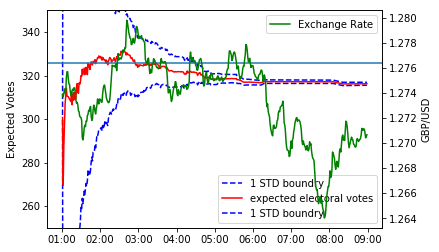

In [75]:
fig, ax1 = plt.subplots()
ax1.plot_date(pred.time, pred.low,'b--', label='1 STD boundry')
ax1.plot_date(pred.time, pred.ave,'r-', label='expected electoral votes')
ax1.plot_date(pred.time, pred.high,'b--', label='1 STD boundry')
plt.ylabel('Expected Votes')
pylab.legend(loc='lower right')
plt.axhline(y=326)
ax1.set_ylim([250,350])

ax2 = ax1.twinx()
ax2.plot(fx['mean'],'g', label='Exchange Rate')

HMFmt = mdates.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(HMFmt)
_ = plt.xticks(rotation=90)

plt.ylabel('GBP/USD')
plt.xlabel('UTC Time')
pylab.legend(loc='upper right')


plt.show()


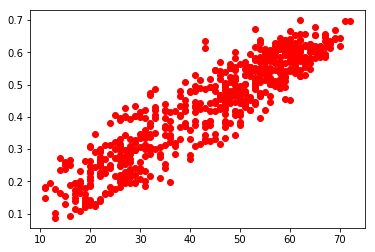

In [76]:
plt.plot(full_table['Con_poll'],full_table['Con[b]'],'ro')
plt.show()

In [77]:
sm.stats.stattools.durbin_watson(model_con.resid)

1.8989380690431743